In [1]:
import numpy as np
import pandas as pd

import os
# import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from wordcloud import WordCloud, STOPWORDS

#Text Color
from termcolor import colored

#Data Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#NLP
from sklearn.feature_extraction.text import CountVectorizer

#WordCloud
from wordcloud import WordCloud, STOPWORDS

#Text Processing
import re
import nltk
nltk.download('popular')


[nltk_data] Error loading popular: <urlopen error [WinError 10053]
[nltk_data]     你的主机中的软件中止了一个已建立的连接。>


False

In [2]:

import langdetect

#Sentiment
from textblob import TextBlob

#ner
import spacy

#Vectorizer
from sklearn import feature_extraction, manifold

#Word Embedding
import gensim.downloader as gensim_api

#Topic Modeling
import gensim

In [3]:
import plotly.express as px
# import hvplot.pandas  # custom install

from glob import glob

from dask import bag, diagnostics 
from urllib import request

import missingno as msno

In [4]:
from PIL import Image

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [6]:
#Image Folder Paths
train_jpg_directory = '..//shopee-product-matching/train_images'
test_jpg_directory = '..//shopee-product-matching/test_images'

In [7]:
def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [8]:
#Get complete image paths for train and test datasets
train_images_path = getImagePaths(train_jpg_directory)
test_images_path = getImagePaths(test_jpg_directory)

In [9]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

In [10]:
test.head()

posting_id                                 image       image_phash  \
0  test_2255846744  0006c8e5462ae52167402bac1c2e916e.jpg  ecc292392dc7687a   
1  test_3588702337  0007585c4d0f932859339129f709bfdc.jpg  e9968f60d2699e2c   
2  test_4015706929  0008377d3662e83ef44e1881af38b879.jpg  ba81c17e3581cabe   

                                               title  
0  Edufuntoys - CHARACTER PHONE ada lampu dan mus...  
1  (Beli 1 Free Spatula) Masker Komedo | Blackhea...  
2   READY Lemonilo Mie instant sehat kuah dan goreng

In [11]:
print(f"Training Dataset Shape: {colored(train.shape, 'yellow')}")
print(f"Test Dataset Shape: {colored(test.shape, 'yellow')}")

Training Dataset Shape: (34250, 5)
Test Dataset Shape: (3, 4)


In [12]:
for col in train.columns:
    print(col + ":" + colored(str(len(train[col].unique())), 'yellow'))

posting_id:34250
image:32412
image_phash:28735
title:33117
label_group:11014


In [13]:
print(f"Number of train images: {colored(len(train_images_path), 'yellow')}")
print(f"Number of test images:  {colored(len(test_images_path), 'yellow')}")

Number of train images: 32412
Number of test images:  3


In [14]:
def display_multiple_img(images_paths, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

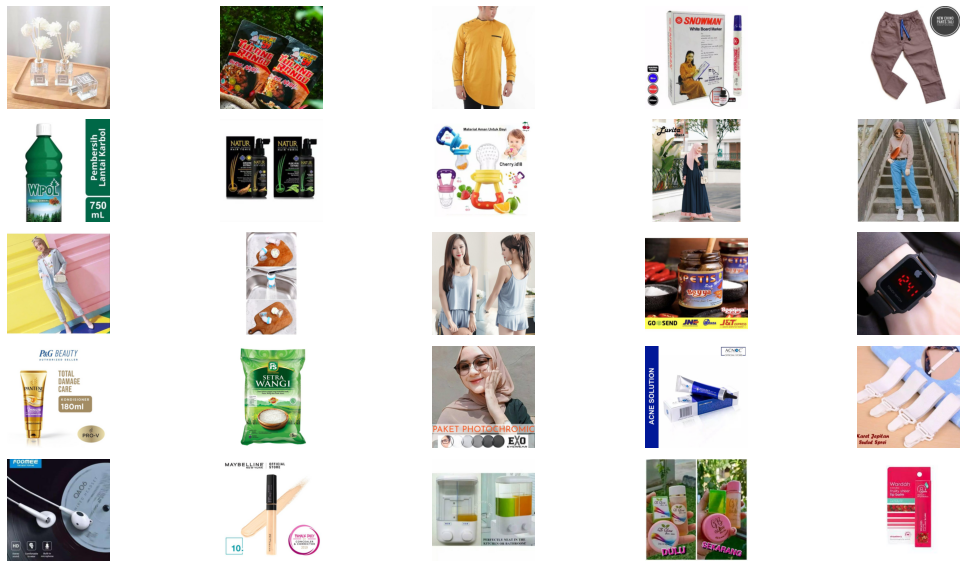

In [15]:
display_multiple_img(train_images_path[100:150], 5, 5)

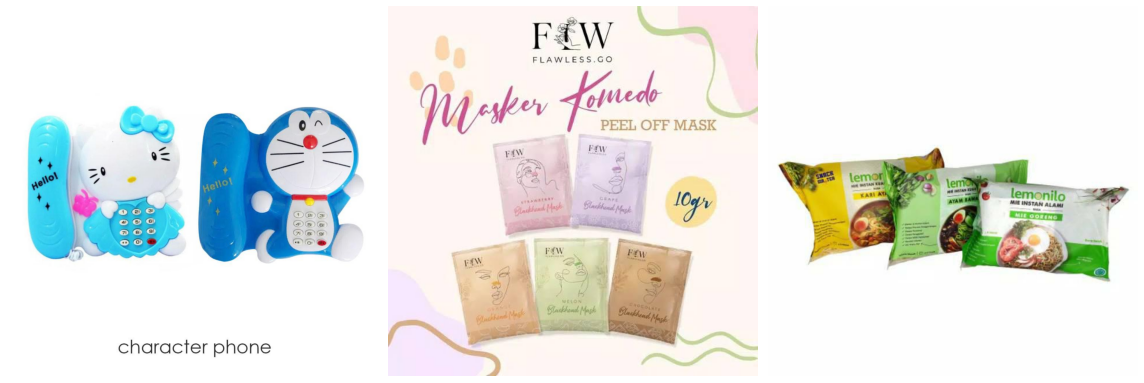

In [16]:
display_multiple_img(test_images_path, 1, 3)

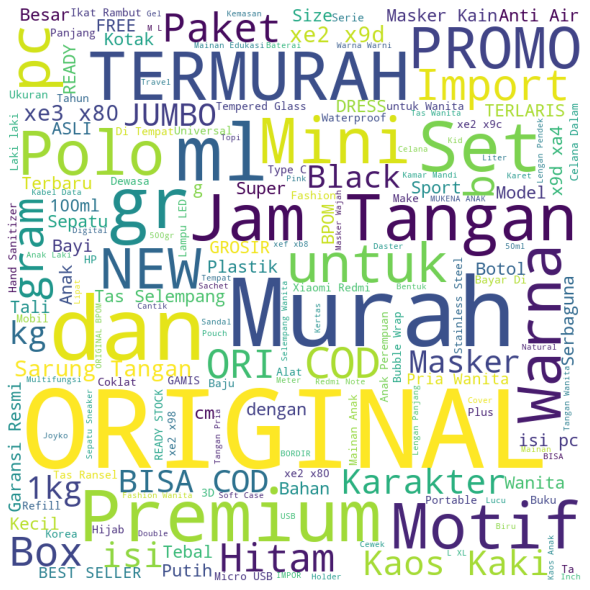

In [17]:
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      min_font_size = 10,
                      stopwords = stopwords,).generate(' '.join(train['title'])) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

Basic NLP

In [18]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True):

    lst_stopwords = nltk.corpus.stopwords.words("english")
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()    
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [19]:
#Clean Address
train["clean_title"] = train["title"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, ))
#Length of Title
train['clean_title_len'] = train['clean_title'].apply(lambda x: len(x))

#Word Count
train['clean_title_word_count'] =train["clean_title"].apply(lambda x: len(str(x).split(" ")))

#Character Count
train['clean_title_char_count'] = train["clean_title"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#Average Word Length
train['clean_title_avg_word_length'] = train['clean_title_char_count'] / train['clean_title_word_count']
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  \
0                          Paper Bag Victoria Secret    249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069   

                                         clean_title  clean_title_len  \
0                          paper bag victoria secret               25   
1  double tape 3m vhb 12 mm x 45 original double ...               55   
2         maling tt canned pork luncheon meat 397 gr               42   
3  daster batik lengan pendek motif acak campur l...               89   
4                    nescafe xc3x89clair latte 220ml               31   

   clean_title_word_count  clean_title_char_count  clean_title_avg_word_length  
0                       4                      22                     5.500000  
1                      12                      44                     3.666667  
2                       8                      35                     4.375000  
3                      13                      77                     5.923077  
4                       4                      28                     7.000000

In [20]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  \
0                          Paper Bag Victoria Secret    249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069   

                                         clean_title  clean_title_len  \
0                          paper bag victoria secret               25   
1  double tape 3m vhb 12 mm x 45 original double ...               55   
2         maling tt canned pork luncheon meat 397 gr               42   
3  daster batik lengan pendek motif acak campur l...               89   
4                    nescafe xc3x89clair latte 220ml               31   

   clean_title_word_count  clean_title_char_count  clean_title_avg_word_length  
0                       4                      22                     5.500000  
1                      12                      44                     3.666667  
2                       8                      35                     4.375000  
3                      13                      77                     5.923077  
4                       4                      28                     7.000000

In [21]:
def plot_distribution(x, title):

    fig = px.histogram(
    train, 
    x = x,
    width = 800,
    height = 500,
    title = title
    )
    
    fig.show()

In [22]:
plot_distribution(x = 'clean_title_len', title = 'Title Length Distribution')

In [23]:
plot_distribution(x = 'clean_title_word_count', title = 'Word Count Distribution')

In [24]:
plot_distribution(x = 'clean_title_char_count', title = 'Character Count Distribution')

In [25]:
plot_distribution(x = 'clean_title_avg_word_length', title = 'Average Word Length Distribution')

Label Exploration

In [26]:
print(f"No. of Unique Label Groups: {colored(train.label_group.nunique(), 'yellow')}")

No. of Unique Label Groups: 11014


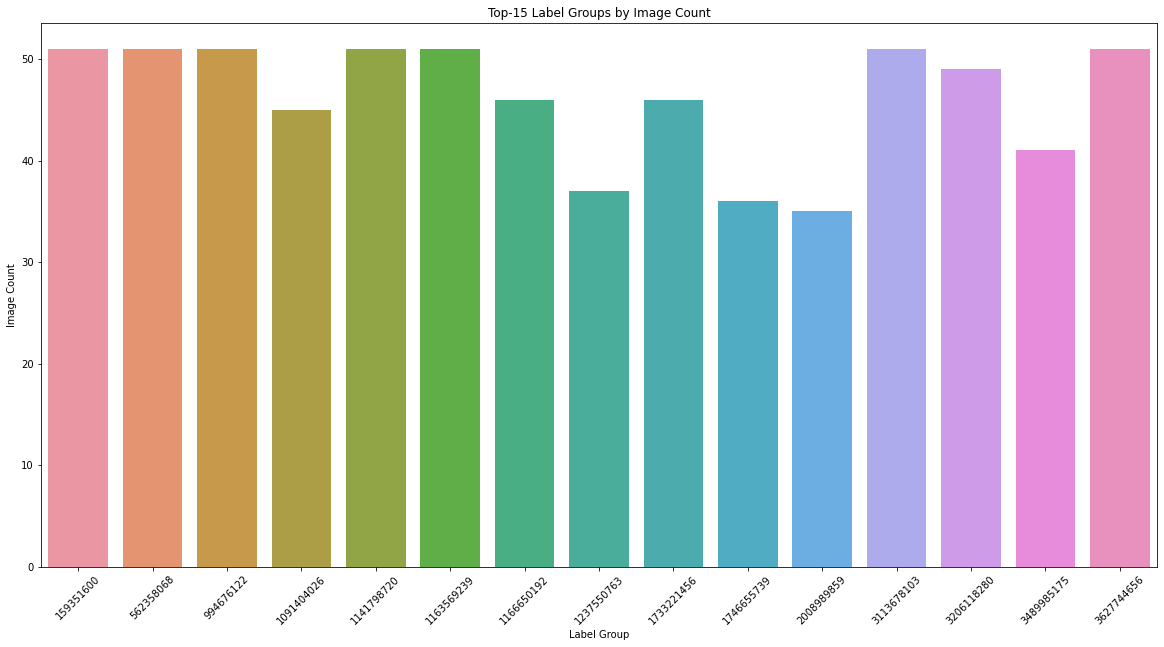

In [27]:
top10_names = train['label_group'].value_counts().index.tolist()[:15]
top10_values = train['label_group'].value_counts().tolist()[:15]

plt.figure(figsize=(20, 10))
sns.barplot(x=top10_names, y=top10_values)
plt.xticks(rotation=45)
plt.xlabel("Label Group")
plt.ylabel("Image Count")
plt.title("Top-15 Label Groups by Image Count")
plt.show()


### Dimensions and 2D Histograms

In [28]:
first = cv2.imread(train_images_path[0])
dims = np.shape(first)
print(dims)

(1024, 1024, 3)


In [29]:
np.min(first), np.max(first)

(0, 255)

In [30]:
pixel_matrix = np.reshape(first, (dims[0] * dims[1], dims[2]))
print(np.shape(pixel_matrix))

(1048576, 3)


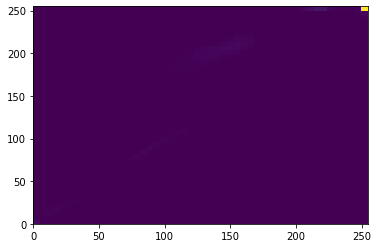

In [31]:
_ = plt.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))

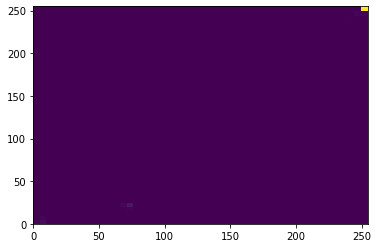

In [32]:
fifth = cv2.imread(train_images_path[4])
dims = np.shape(fifth)
pixel_matrix5 = np.reshape(fifth, (dims[0] * dims[1], dims[2]))
_ = plt.hist2d(pixel_matrix5[:,1], pixel_matrix5[:,2], bins=(50,50))

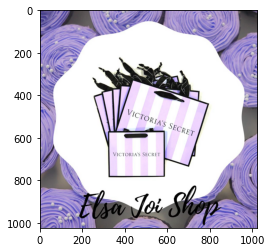

In [33]:
plt.imshow(first)

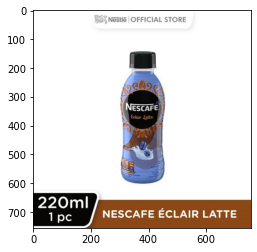

In [34]:
plt.imshow(fifth)

### K-means Clustering

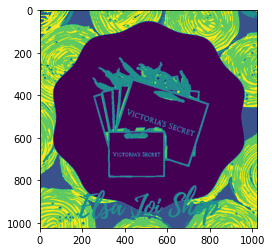

In [35]:
# simple k means clustering
from sklearn import cluster

kmeans = cluster.KMeans(5)
clustered = kmeans.fit_predict(pixel_matrix)

dims = np.shape(first)
clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)

In [36]:
ind0, ind1, ind2, ind3 = [np.where(clustered == x)[0] for x in [0, 1, 2, 3]]

Text(0.5, 0, 'Red channel')

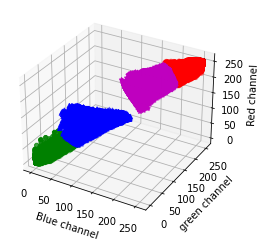

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_vals = [('r', 'o', ind0),
             ('b', '^', ind1),
             ('g', '8', ind2),
             ('m', '*', ind3)]

for c, m, ind in plot_vals:
    xs = pixel_matrix[ind, 0]
    ys = pixel_matrix[ind, 1]
    zs = pixel_matrix[ind, 2]
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('Blue channel')
ax.set_ylabel('green channel')
ax.set_zlabel('Red channel')

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

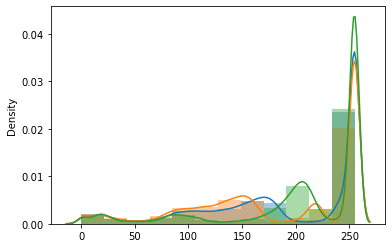

In [38]:
# quick look at color value histograms for pixel matrix from first image
import seaborn as sns
sns.distplot(pixel_matrix[:,0], bins=12)
sns.distplot(pixel_matrix[:,1], bins=12)
sns.distplot(pixel_matrix[:,2], bins=12)

In [39]:
img79_1, img79_2, img79_3, img79_4, img79_5 = [plt.imread(train_images_path[n]) for n in range(78, 83)]

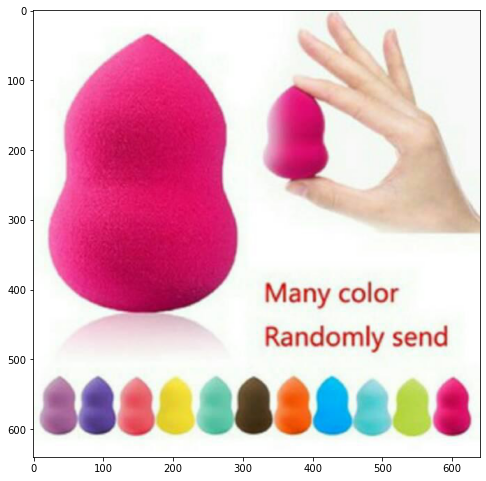

In [40]:
img_list = (img79_1, img79_2, img79_3, img79_4, img79_5)

plt.figure(figsize=(8,10))
plt.imshow(img_list[0])
plt.show()

In [41]:
class MSImage():
    """Lightweight wrapper for handling image to matrix transforms. No setters,
    main point of class is to remember image dimensions despite transforms."""
    
    def __init__(self, img):
        """Assume color channel interleave that holds true for this set."""
        self.img = img
        self.dims = np.shape(img)
        self.mat = np.reshape(img, (self.dims[0] * self.dims[1], self.dims[2]))

    @property
    def matrix(self):
        return self.mat
        
    @property
    def image(self):
        return self.img
    
    def to_flat_img(self, derived):
        """"Use dims property to reshape a derived matrix back into image form when
        derived image would only have one band."""
        return np.reshape(derived, (self.dims[0], self.dims[1]))
    
    def to_matched_img(self, derived):
        """"Use dims property to reshape a derived matrix back into image form."""
        return np.reshape(derived, (self.dims[0], self.dims[1], self.dims[2]))

In [42]:
msi79_1 = MSImage(img79_1)
print(np.shape(msi79_1.matrix))
print(np.shape(msi79_1.img))

(409600, 3)
(640, 640, 3)


In [43]:
def bnormalize(mat):
    """much faster brightness normalization, since it's all vectorized"""
    bnorm = np.zeros_like(mat, dtype=np.float32)
    maxes = np.max(mat, axis=1)
    bnorm = mat / np.vstack((maxes, maxes, maxes)).T
    return bnorm

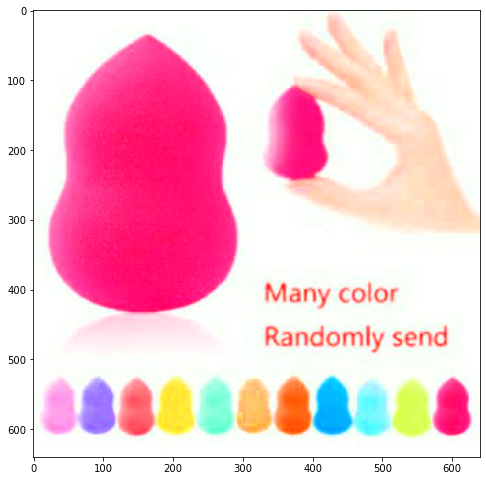

In [44]:
bnorm = bnormalize(msi79_1.matrix)
bnorm_img = msi79_1.to_matched_img(bnorm)
plt.figure(figsize=(8,10))
plt.imshow(bnorm_img)
plt.show()

<ipython-input-43-b22ed807d827>:5: RuntimeWarning:

invalid value encountered in true_divide



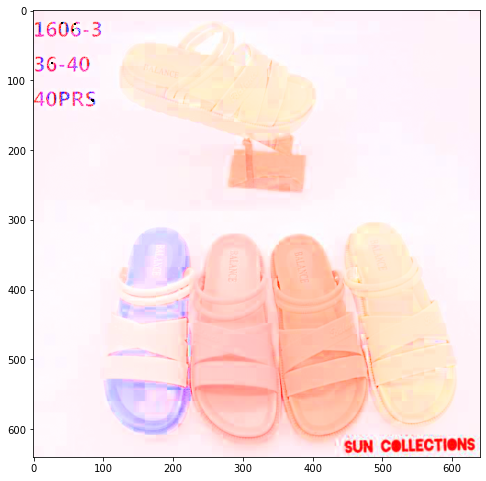

In [45]:
msi79_2 = MSImage(img79_2)
bnorm79_2 = bnormalize(msi79_2.matrix)
bnorm79_2_img = msi79_2.to_matched_img(bnorm79_2)
plt.figure(figsize=(8,10))
plt.imshow(bnorm79_2_img)
plt.show()

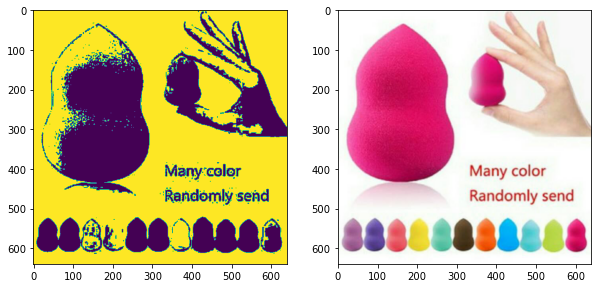

In [46]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.imshow(img79_1[:,:,0] > 230)
plt.subplot(122)
plt.imshow(img79_1)
plt.show()

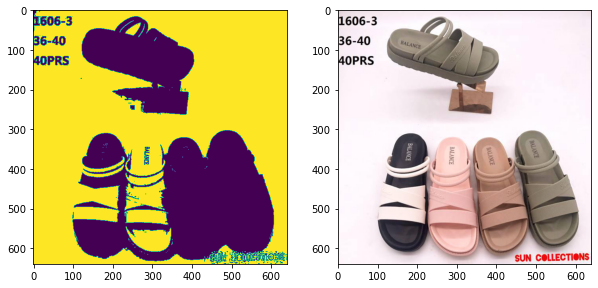

In [47]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.imshow(img79_2[:,:,0] > 230)
plt.subplot(122)
plt.imshow(img79_2)
plt.show()